# 0.0. Imports

In [2]:
import numpy  as np
import pandas as pd
import boruta as bt
import scikitplot as skplt
import pickle
import psycopg2 as pg
import warnings
import random
warnings.filterwarnings('ignore')


import seaborn as sns

from matplotlib import pyplot as plt
from tabulate import tabulate
from IPython.display          import Image
from scipy                 import stats     as ss

from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier   

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

# 0.1. Helper Functions

In [6]:
n = round(0.26*76222)
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 100
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    return None

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def precision_at_k (data, k ):
    #reset index
    data = data.reset_index(drop = True)
    
    # Create ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[k, 'precision_at_k'])






def recall_at_k( data, k ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return (data.loc[k, 'recall_at_k'])

def gain_lift_curve(yhat, yval, plot = True):
    '''
    plots gain and lift curve, respectively
    returns the curves and a table used to plot the curves
    '''

    # create table proba with the propensity score for each class (0 and 1)
    table_proba = pd.DataFrame(yhat)

    # add the 'response' column
    table_proba['target'] = yval.values

    # add the 'correct' column to evaluate wheter the prediction was right or not
    x = lambda x: "yes" if x[0] > x[1] and x['target'] == 0 else "yes" if x[1] > x[0] and x['target'] == 1 else "yes" if x[0] == x[1] else "no"
    table_proba['correct'] = table_proba.apply(x, axis = 1)

    # order by propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('target').count().loc[1,1]

    ## apply a score for every row which target is 1
    x = lambda x: 1/qty_class_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(8, 10))

        # gap between graphics
        fig.tight_layout(pad =5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_propensity_score'], label="cumulative (model)", linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_porc_base'], label="baseline", linewidth = 2.5, color = 'black' )
        axes[0].lines[1].set_linestyle("--")
        axes[0].legend()
        axes[0].set_title("cumulative gains curve")
        axes[0].set_xlabel("percentage of sample")
        axes[0].set_ylabel("gain")

        # lift curve
        ## do not consider the beginning of the series, as it varies a lot (the sample is still small)
        table_proba_filtered = table_proba.query('cumulative_porc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = table_proba_filtered['lift'], label="model", linewidth = 2.5 );
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = np.ones(len(table_proba_filtered)), label="baseline", linewidth = 2.5, color = 'black' )
        axes[1].lines[1].set_linestyle("--")
        axes[1].legend()
        axes[1].set_title("lift curve")
        axes[1].set_xlabel("percentage of sample")

        plt.show();

    return (table_proba)



def precision_recall_at_k(table, k = n):
    '''
    receives the table that was generated in gain_lift_curve function and returns:
    - a tuple containg the precision at k and recall at k, respectively
    - a new table with precision_at_k and recall_at_k metrics
    '''
    table.reset_index(drop=True, inplace = True)
    table['ranking'] = table.index + 1 # as the index starts in 0 it is necessary to +1
    table['precision_at_k'] = table['target'].cumsum() / table['ranking']
    table['recall_at_k'] = table['target'].cumsum() / table['target'].sum()
    return ((table.loc[k-1, 'precision_at_k'], table.loc[k-1, 'recall_at_k']),table) # as the loc uses index, it is necessary to -1 to return the desired k




def runCrossValidation (model, x_train, x_val, y_train, y_val, n_splits, n_repeats, top_k = n, verbose=False):

    if verbose:
        # the lenght_msg is to print only once a specific message
        length_msg = True
        i = 1

    # the seed usage provides repeatability
    np.random.seed(1231234)

    # it is necessary to join the train and validation datasets
    x = pd.concat([x_train, x_val])
    y = pd.concat([y_train, y_val])

    # definition of the cross-validation strategy
    # - the "n_splits" parameter is the number of folds (k)
    # - the "n_repeats" parameter is the number of times cross-validator needs to
    #   be repeated
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats )

    precision_at_k = []
    recall_at_k = []

    for train_index, prim_val_index in cv.split(x, y):
        x_training, x_prim_val = x.iloc[train_index], x.iloc[prim_val_index]
        y_training, y_prim_val = y.iloc[train_index], y.iloc[prim_val_index]

        if (verbose == True) and (length_msg == True):
            print(f'training_lenght:{x_training.shape[0]}\nvalidation_lenght:{x_prim_val.shape[0]}\n\n')
            length_msg = False

        if verbose:
            print(f'Iteration number:{i}')
            i += 1

        # fit and predict_proba
        model.fit(x_training, y_training)
        yhat_proba = model.predict_proba(x_prim_val)

        # get results
        table = gain_lift_curve(yhat_proba,y_prim_val, plot = False)
        metrics, new_table = precision_recall_at_k(table, top_k)

        if verbose:
            print(metrics)
            print('')

        # save the metrics value to the list
        precision_at_k.append(metrics[0])
        recall_at_k.append(metrics[1])

    df_results = pd.DataFrame([[np.mean(precision_at_k),np.std(precision_at_k)],
                       [np.mean(recall_at_k), np.std(recall_at_k)]],
                      columns = ["mean", "std"])

    df_results.index = ["precision_at_k","recall_at_k"]

    return(df_results)





# 0.2. Load dataset

## 0.2.1 Connect Database and Extract Data

In [7]:
# HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# PORT = '5432'
# DATABASE = 'comunidadedsdb'
# USER = 'member'
# PASSWORD ='cdspa'

# conn = pg.connect( host=HOST,
#                   database=DATABASE,
#                   port=PORT,
#                   user=USER,
#                   password=PASSWORD )

# query = """
#    SELECT *
#    FROM pa004.users u INNER JOIN pa004.vehicle v ON ( u.id = v.id )
#                       INNER JOIN pa004.insurance i ON ( u.id = i.id )
#    ORDER BY u.id 
# """

# df_raw = pd.read_sql( query, conn )
# conn.close()

In [8]:
# # remove duplicate columns (i.e. the 'id' from vehicle and insurance tables)
# df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]

# # saving the data in csv format
# df_raw.to_csv( '../data/raw/train.csv' )


## 0.2.2 Loading raw CSV

In [9]:
df_raw = pd.read_csv( '../data/raw/train.csv' )

In [10]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [11]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [12]:
# Renaming Columns
cols_new = df1.columns.to_list()
cols_new = [word.lower() for word in cols_new]
df1.columns = cols_new


## 1.2.Columns Description

In [13]:
#Double check understanding of each column

tab_meanings = [['Column', 'Meaning'],
    #####################################################  
        ['id', 'unique customer identifier.'],
        ['gender', 'client gender: Male / Female.'],
        ['age', 'customer age.'],
        ['region_code', 'customer region code.'],
        ['policy_sales_channel', 'Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..'],
        ['driving_license', '0 = customer does not have DL, 1 = already have DL'],
        ['vehicle_age', 'vehicle age: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = customer has never had their vehicle damaged in the past, Yes = has had it.'],
        ['vehicle_prev_insured', '0 = customer does not have vehicle insurance, 1= already has vehicle insurance.'],
        ['health_annual_premium', 'annual amount paid by the customer to the company for health insurance. Currency: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],
        ['days_associated', 'number of days since the customer joined the company by purchasing health insurance. The policy is annual.'],
        ['response', '0 = customer is not interested, 1 = customer is interested.']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='rst'))

=====================  =========================================================================================================================
Column                 Meaning
=====================  =========================================================================================================================
id                     unique customer identifier.
gender                 client gender: Male / Female.
age                    customer age.
region_code            customer region code.
policy_sales_channel   Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..
driving_license        0 = customer does not have DL, 1 = already have DL
vehicle_age            vehicle age: < 1 Year, 1-2 Year, > 2 Years
vehicle_damage         No = customer has never had their vehicle damaged in the past, Yes = has had it.
vehicle_prev_insured   0 = customer does not have vehicle insurance, 1= already has vehicle insurance.
health_annual_p

## 1.3. Data Dimensions

In [14]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.4. Data Types

In [15]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [16]:
#convert df['region_code'] to int:
df1['region_code'] = df1['region_code'].astype(int)
#convert df['policy_sales_channel'] to int:
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

In [17]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code               int64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel      int64
vintage                   int64
response                  int64
dtype: object

## 1.5. Check NA

In [18]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.8. Fill NA 

In [19]:
# Not Necessary

## 1.9. Data Descriptive

In [20]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [21]:
#separate cathegorical and numerical attributes
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['gender','region_code','policy_sales_channel','driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

### 1.9.1. Numerical Attributes

In [22]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) )
ct2 = pd.DataFrame( num_attributes.apply( np.median ) )

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ) 
d2 = pd.DataFrame( num_attributes.apply( min ) ) 
d3 = pd.DataFrame( num_attributes.apply( max ) )
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ) 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ) 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) )

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


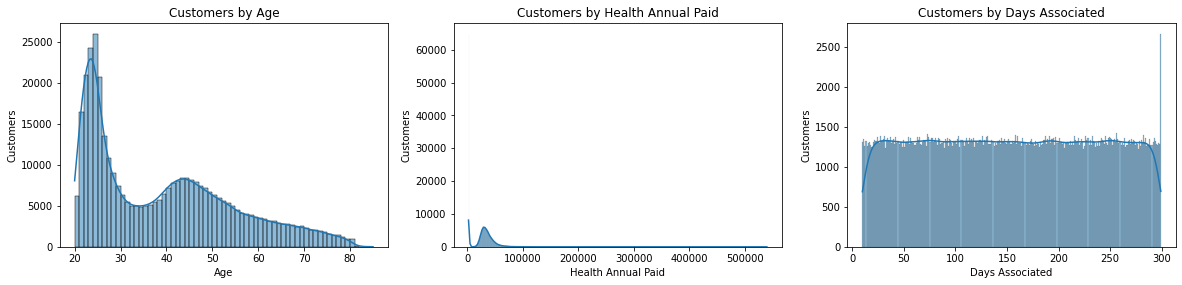

In [23]:
#Num Attributes plot
plt.figure(figsize=(20,14))

plt.subplot(3,3,1)
age_hist = sns.histplot(df1['age'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(3,3,2)
hap_hist = sns.histplot(df1['annual_premium'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('Health Annual Paid')
hap_hist.set_title('Customers by Health Annual Paid');

plt.subplot(3,3,3)
da_hist = sns.histplot(df1['vintage'], binwidth=1, kde=True);
da_hist.set_ylabel('Customers')
da_hist.set_xlabel('Days Associated')
da_hist.set_title('Customers by Days Associated');

Highlights:
- age: mean = 36y, 1 std = 15.5 
- annual_premium: very big range of 537535, high kurtosis, many extreme values.
- days_associated: very uniform, probably will not help much.

### 1.9.2 Cathegorical Attributes

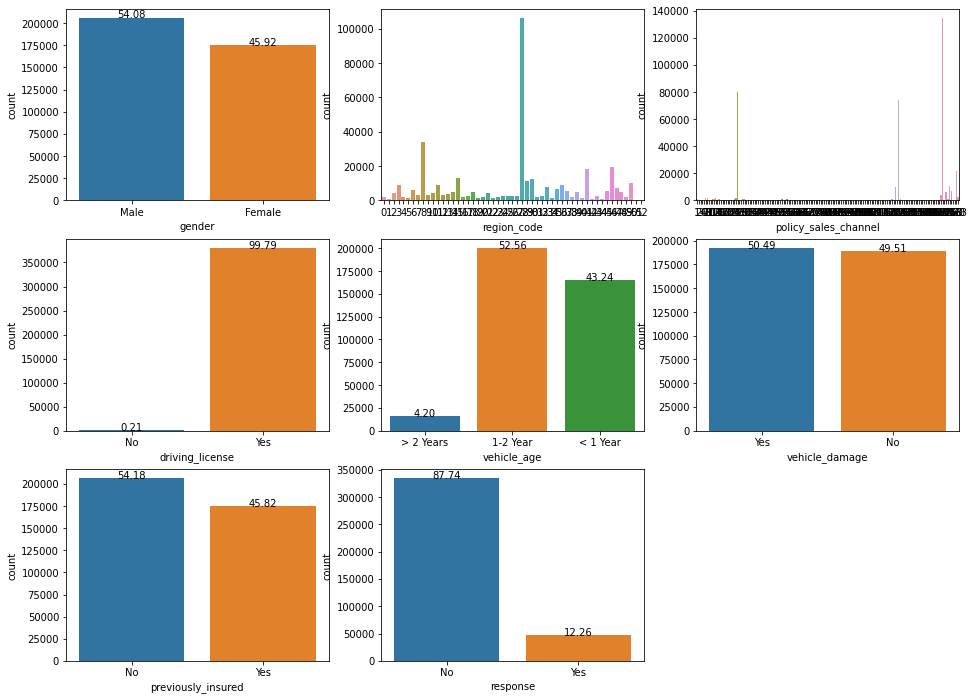

In [24]:
plt.figure(figsize=(16,12))

plt.subplot (3,3,1)
ax = sns.countplot (x = cat_attributes['gender']);
total=len(cat_attributes['gender'])
graphic_percentage(ax,total)

plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['region_code']);

plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['policy_sales_channel']);

plt.subplot (3,3,4)
ax = sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);
total=len(cat_attributes['driving_license'])
graphic_percentage(ax,total)

plt.subplot (3,3,5)
ax = sns.countplot (x = cat_attributes['vehicle_age']);
total=len(cat_attributes['vehicle_age'])
graphic_percentage(ax,total)

plt.subplot (3,3,6)
ax = sns.countplot (x = cat_attributes['vehicle_damage']);
total=len(cat_attributes['vehicle_damage'])
graphic_percentage(ax,total)

plt.subplot (3,3,7)
ax = sns.countplot (x = cat_attributes['previously_insured']);
plt.xticks([0,1],['No','Yes']);
total=len(cat_attributes['previously_insured'])
graphic_percentage(ax,total)

plt.subplot (3,3,8)
ax = sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['No','Yes']);
total=len(cat_attributes['response'])
graphic_percentage(ax,total)

### 1.10. Extracting Data for Test

In [25]:
df1.shape

(381109, 12)

In [26]:
# Test Dataset Extraction
X = df1.drop('response', axis = 1).copy()
y = df1['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 45)

# df5 is the new dataset, and will be used to train and validate the models
df2 = pd.concat([x_train, y_train], axis = 1)

# df_test is a separate dataset, and will be used to perfomr the final evaluation of the trained model
df_test = pd.concat([x_test, y_test], axis = 1)

In [27]:
#Check test stratify
df_test['response'].value_counts(normalize= True)

0    0.877437
1    0.122563
Name: response, dtype: float64

In [28]:
#Check train stratify
df2['response'].value_counts(normalize= True)

0    0.877437
1    0.122563
Name: response, dtype: float64

In [29]:
#save datasets 
df2.to_csv('../data/df2_data_description_done.csv')
df_test.to_csv('../data/full_test_data.csv')

# 2.0. Feature Engineering

## 2.1 Hypotheses Mindmap

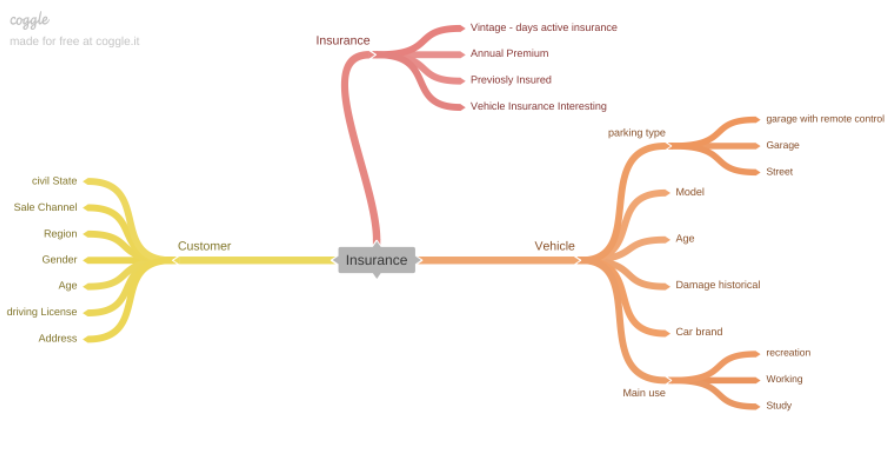

In [30]:
Image('../Images/Mindmap_RFFB.PNG')

## 2.2. Hyphoteses

**H1-** Interest is greater in customers with HIGHER AGE

**H2-** Interest is greater in FEMALE CUSTOMERS.

**H3-** Interest is greater in customers WITH MOST RECENT VEHICLE AGE

**H4-** Interest is greater in customers who HAD VEHICLE DAMAGE

**H5-** Interest is greater in Customers who HAD VEHICLE PREVIOUSLY INSURED.

**H6-** Interest is greater in customers with HIGHER ANNUAL HEALTH EXPANSES.

**H7-** Interest is greater in customers whth MORE DAYS ASSOCIATED.

## 2.3. Feature Engineering

In [31]:
# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0. Data Filtering

In [32]:
#no business related data evaluated as needed to exclude looking at Data Description
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis

In [33]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Age

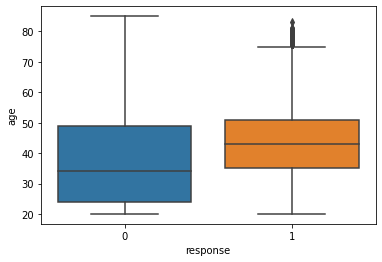

In [34]:
# age
# as medianas são rasoavelmente diferentes, o que indica que essa variável pode impactar o fenômeno . Nas pessoas que não tem interesse, 
# tem uma concentração muito grande em pessoas novas, e depois decai, se assemelhando a uma distribuição de Poisson. Já nas que tem interesse,
# a distribuição se parece com uma normal onde pessoas de meia idade são as que tem mais interesse

sns.boxplot(x='response',y= 'age',data= df4);

<AxesSubplot:xlabel='age', ylabel='Count'>

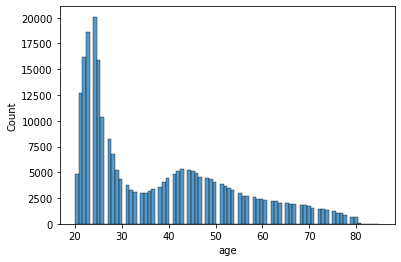

In [35]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

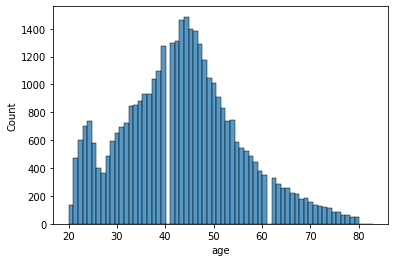

In [36]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

### 4.1.2. Anual Income

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

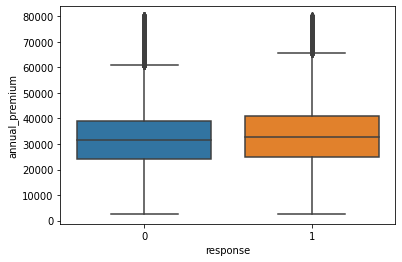

In [37]:
# annual_premium

# Não há muita diferença entre as medianas e as distribuições são muito parecidas, por isso, essa variável sozinha não diz muito
# sobre o fenômeno

aux = df4 [ df4[ 'annual_premium'] < 80000]
sns.boxplot(x = 'response', y = 'annual_premium', data = aux)

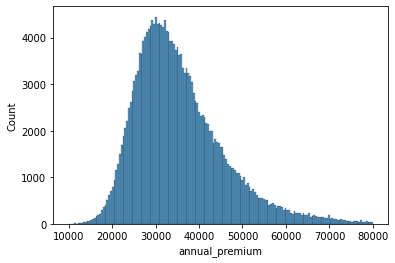

In [38]:
aux = df4 [ (df4[ 'annual_premium'] > 10000) & (df4[ 'annual_premium'] < 80000)]
aux00 = aux.loc[aux['response']==0 , 'annual_premium']
sns.histplot(aux00);

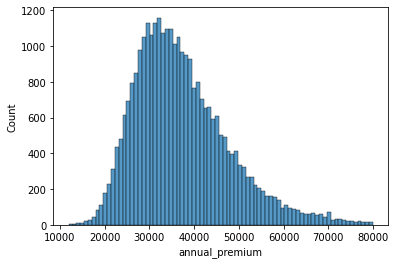

In [39]:
aux = df4 [ (df4[ 'annual_premium'] > 10000) & (df4[ 'annual_premium'] < 80000)]
aux00 = aux.loc[aux['response']==1 , 'annual_premium']
sns.histplot(aux00);

### 4.1.3. Driving License

In [40]:
# driving_license
# é até contra intuitivo pessoas que não tem carteira de motorista que tem interesse em seguro de carro, a não ser que seja
# para os familiares

aux = df4[['driving_license', 'response', 'id']].groupby(['driving_license', 'response']).count().reset_index()
aux = aux.rename(columns={'id':'count'})
aux.head()


,driving_license,response,count
0,0,0,631
1,0,1,29
2,1,0,266888
3,1,1,37339


### 4.1.4. Region Code

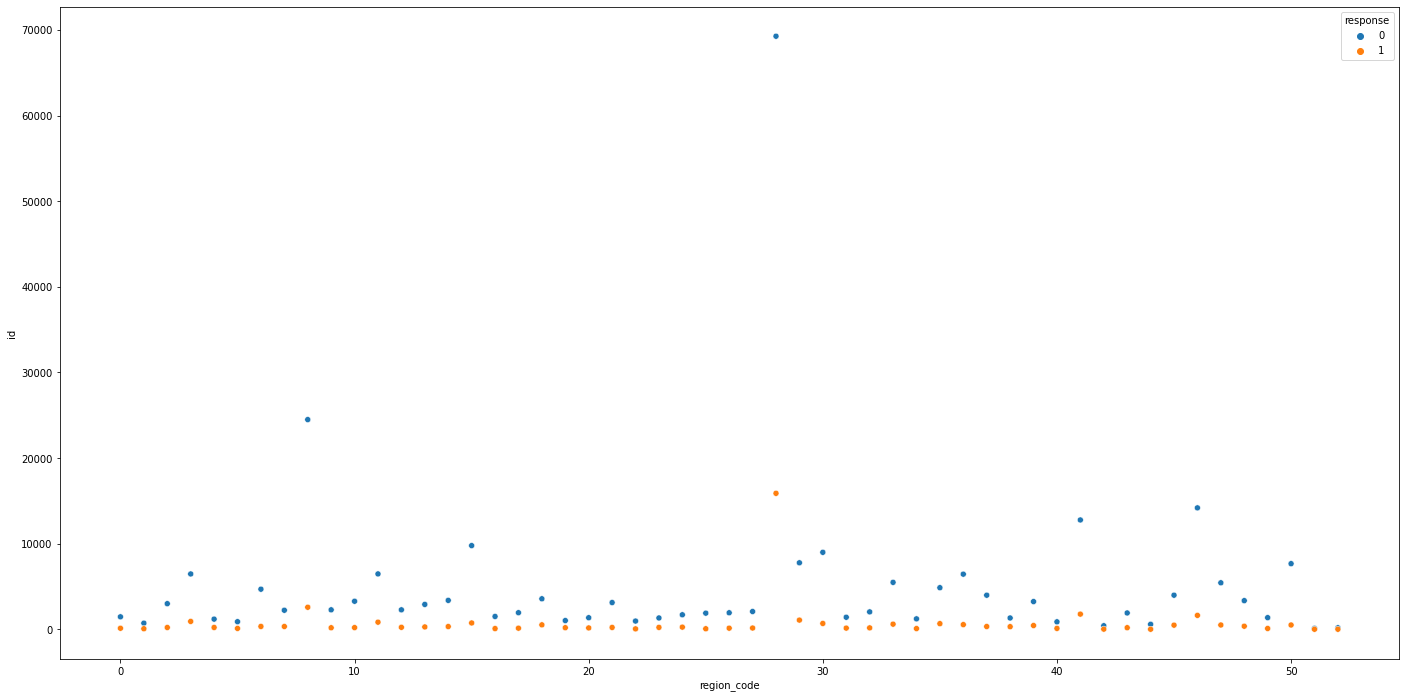

In [41]:
# region_code
# é inconclusivo porque para a maioria das region_codes ela não é uma variável discriminatória, com exceção por exemplo da region_code 28
# na maioria, response 1 e 0 estão com a contagem muito parecida
plt.figure (figsize = (24,12))
aux = df4[['region_code', 'response', 'id']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x= 'region_code', y= 'id', hue = 'response', data= aux);

### 4.1.5. Previously Insured

<AxesSubplot:xlabel='previously_insured', ylabel='id'>

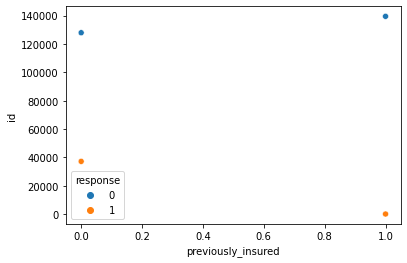

In [42]:
aux0 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='previously_insured', y='id', hue='response', data=aux0 )

In [43]:
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774646,0.225354
1,0.999033,0.000967


### 4.1.6. Vehicle Age

In [44]:
# vehicle_age
# pode ser uma variável com impacto significante na variável resposta, pois quanto mais velho o carro, mais as pessoas tem interesse
# em contratar o seguro
pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x : x / x.sum(), axis = 1)

response,0,1
vehicle_age,,
below_1_year,0.956399,0.043601
between_1_2_year,0.826122,0.173878
over_2_years,0.706231,0.293769


### 4.1.7. Vehicle Damage

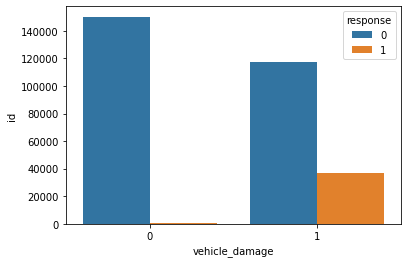

In [45]:
# claramente é uma variável descriminatória, pois a proporção de pessoas que tem interesse no seguro é muito maior em pessoas
# que já sofreram danos em seus carros
aux = df4[['id','vehicle_damage', 'response']].groupby( ['vehicle_damage','response'] ).count().reset_index()
sns.barplot( x='vehicle_damage', y='id',hue= 'response', data=aux );

### 4.1.8. Policy Sales Channel - Stacked Percentage Bar

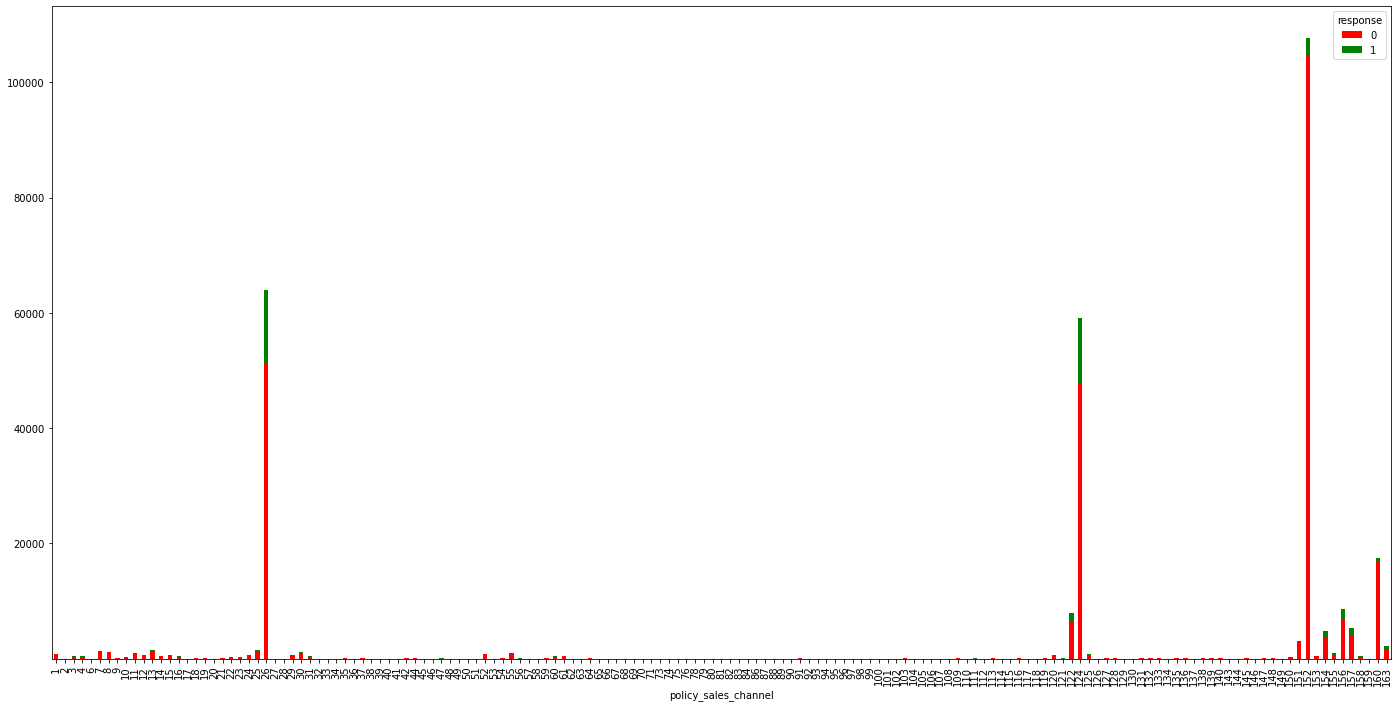

In [46]:
plt.rcParams['figure.figsize'] = [24, 12]
aux = pd.crosstab(df4['policy_sales_channel'], df4['response'])
aux.plot(kind='bar', stacked=True, color=['red',  'green'])
plt.xticks( rotation = 90)
plt.show()
plt.rcParams['figure.figsize'] = [6,4 ]

In [47]:
# policy_sales_channel

# pode ser uma variável discriminatória, pois em certos canais, as pessoas responderam em sua totalidade que não tinham interesse no 
# seguro de carros
from IPython.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 10):
    aux = pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x : x/ x.sum(), axis =1).sort_values(0, ascending=False)
    display (aux)

response,0,1
policy_sales_channel,,
75,1.000000,0.000000
99,1.000000,0.000000
95,1.000000,0.000000
84,1.000000,0.000000
83,1.000000,0.000000
82,1.000000,0.000000
2,1.000000,0.000000
79,1.000000,0.000000
76,1.000000,0.000000


### 4.1.9. Vintage

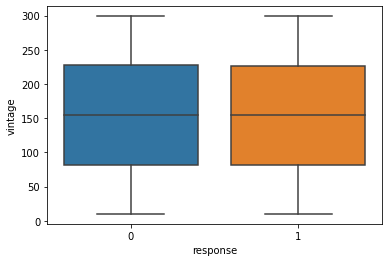

In [48]:
# vintage
# Pela distribuição da variável percebemos que a base é homegenea em relação ao número de dias que as pessoas estão associadas
# a compania e pelo boxplot percebemos que não há distinção entre as pessoas que tem interesse e não tem interesse no seguro
# por esse aspecto
sns.boxplot(x = 'response', y = 'vintage', data = df4);

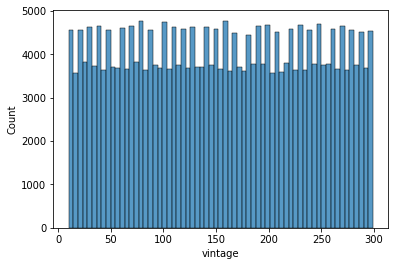

In [49]:
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux );

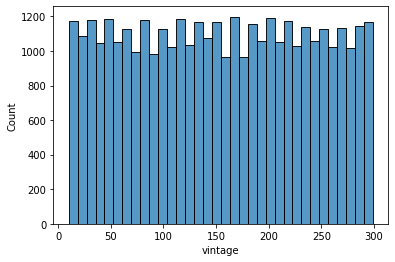

In [50]:
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux );

## 4.2. Bivariate Analysis

### H1- Interest is greater in customers with HIGHER AGE.

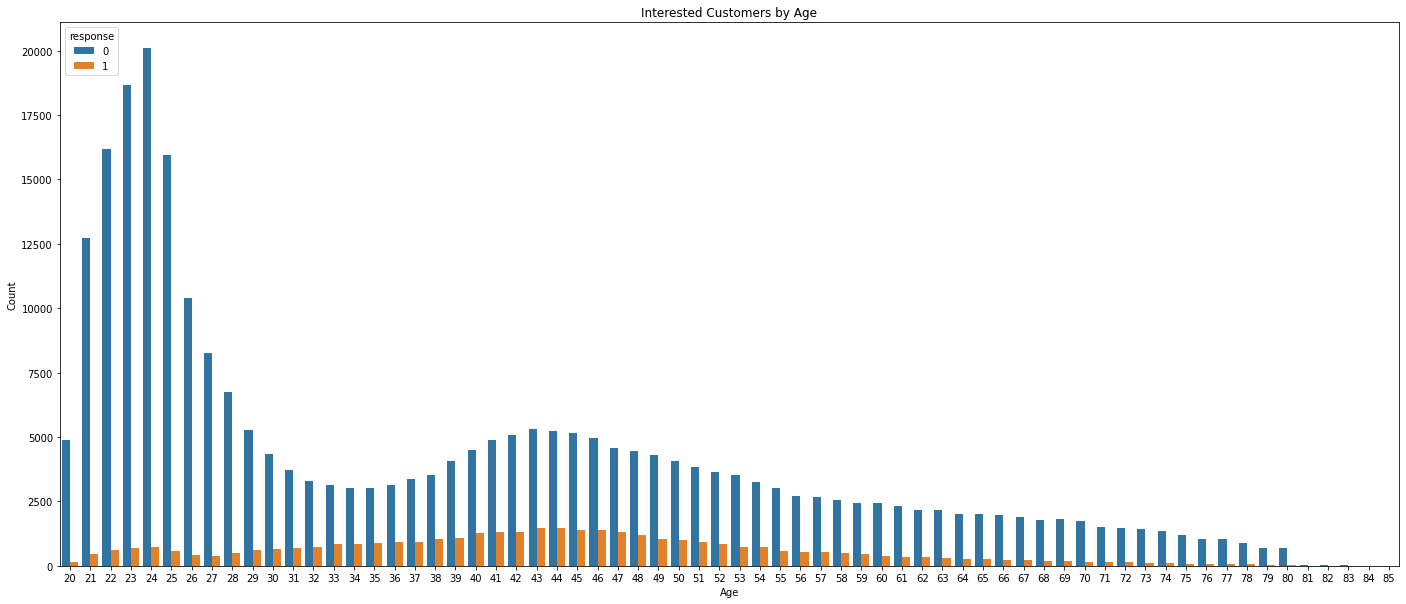

In [51]:
plt.figure(figsize=(24,10))
eda_age1=df4[['age','response']].groupby(['age','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=eda_age1,x='age',y='qtd',hue='response')
ax.set_title('Interested Customers by Age')
ax.set_xlabel('Age')
ax.set_ylabel('Count');


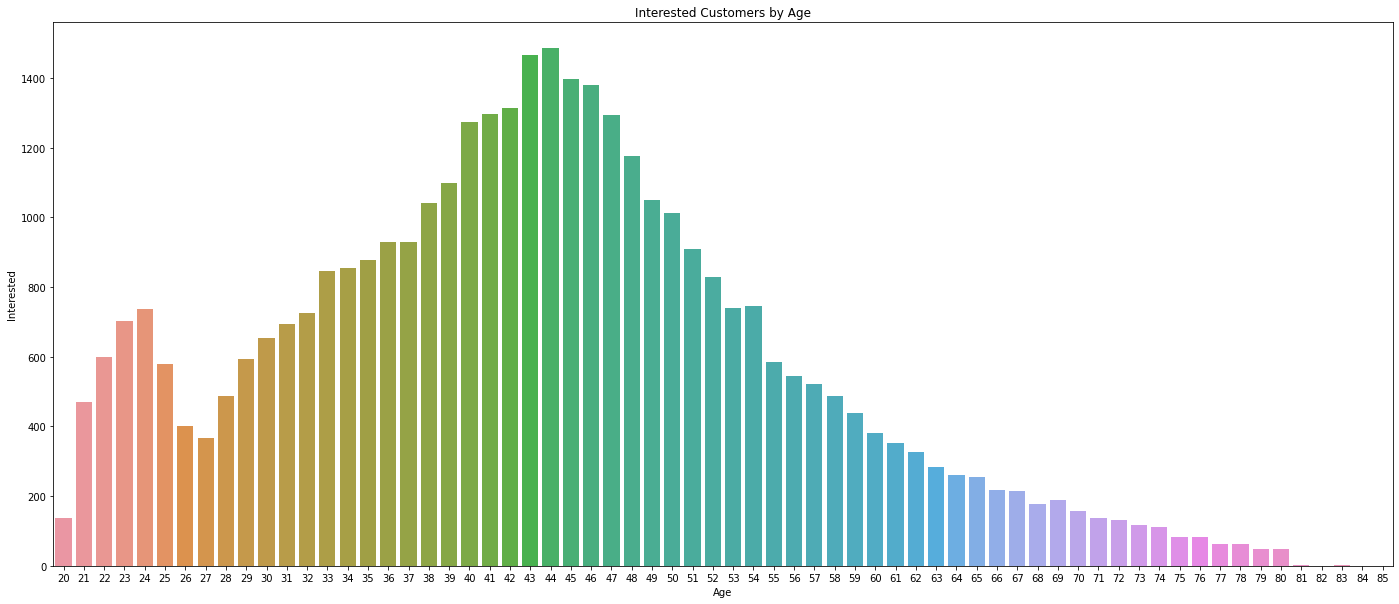

In [52]:
# Analyse just interested customers by age
plt.figure(figsize=(24,10))
aux_age2 = df4[['age', 'response']].groupby('age').sum().reset_index()
eda_age2 = sns.barplot( x='age', y='response', data=aux_age2 )
eda_age2.set_title('Interested Customers by Age')
eda_age2.set_xlabel('Age')
eda_age2.set_ylabel('Interested');

 False hypothesis: Customers between 40-45 years old are the most interested in vehicle insurance. 
 
 Interest in vehicle insurance decreases between 24-27 years old and after 44 years old.

### H2- Interest is greater in FEMALE CUSTOMERS.

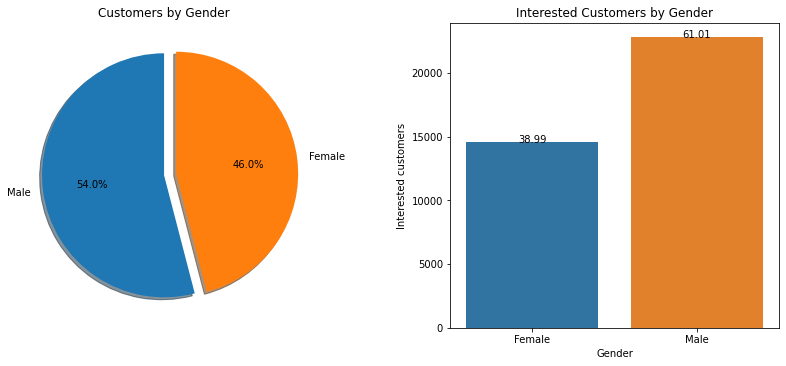

In [53]:
# Gender Interest Dashboard
#percentage of customers per gender
plt.figure(figsize=(12,6))
pie1_gen = plt.subplot (1,2,1)

pie1_gen.set_title('Customers by Gender')
perc_m, perc_f = df4['gender'].value_counts(normalize= True)
pie1_gen.pie([perc_m, perc_f], explode=(0, 0.1), labels=['Male', 'Female'], autopct='%1.1f%%', shadow=True, startangle=90)

#interested customers per gender
ax = plt.subplot (1,2,2)

# labels
aux=df4[df4['response']==1]
aux=aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd')
total=sum(aux['qtd'])
graphic_percentage(ax,total)

ax.set_title('Interested Customers by Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Interested customers')
plt.tight_layout(pad=4)

False hypothesis: 54% of customers are male, and 61% of interested customers in vehicle insurance are male.

### H3- Interest is greater in customers WITH MOST RECENT VEHICLE AGE.

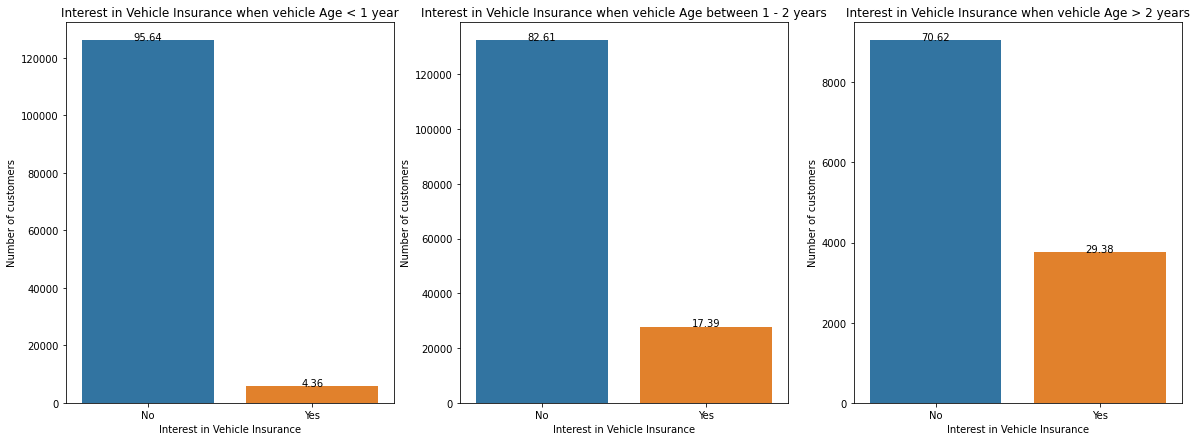

In [54]:
plt.rcParams["figure.figsize"] = (20, 7)

plt.subplot (1,3,1)
h3_df_below = df4.loc[df4['vehicle_age'] == 'below_1_year']
h3_int_below = h3_df_below[['vehicle_age', 'response']].groupby('response').count().reset_index()
fig_below_h3 = sns.barplot (x = 'response', y='vehicle_age', data=h3_int_below);
fig_below_h3.set_xlabel('Interest in Vehicle Insurance')
fig_below_h3.set_ylabel('Number of customers')
fig_below_h3.set_title('Interest in Vehicle Insurance when vehicle Age < 1 year');
fig_below_h3.set_xticklabels(['No', 'Yes']);
total=h3_df_below['response'].count()
graphic_percentage(fig_below_h3,total)

plt.subplot (1,3,2)
h3_df_between = df4.loc[df4['vehicle_age'] == 'between_1_2_year']
h3_int_between = h3_df_between[['vehicle_age', 'response']].groupby('response').count().reset_index()
fig_between_h3 = sns.barplot (x = 'response', y='vehicle_age', data=h3_int_between);
fig_between_h3.set_xlabel('Interest in Vehicle Insurance')
fig_between_h3.set_ylabel('Number of customers')
fig_between_h3.set_title('Interest in Vehicle Insurance when vehicle Age between 1 - 2 years');
fig_between_h3.set_xticklabels(['No', 'Yes']);
total=h3_df_between['response'].count()
graphic_percentage(fig_between_h3,total)

plt.subplot (1,3,3)
h3_df_over = df4.loc[df4['vehicle_age'] == 'over_2_years']
h3_int_over = h3_df_over[['vehicle_age', 'response']].groupby('response').count().reset_index()

fig_over_h3 = sns.barplot (x = 'response', y='vehicle_age', data=h3_int_over);
fig_over_h3.set_xlabel('Interest in Vehicle Insurance')
fig_over_h3.set_ylabel('Number of customers')
fig_over_h3.set_title('Interest in Vehicle Insurance when vehicle Age > 2 years');
fig_over_h3.set_xticklabels(['No', 'Yes']);
total=h3_df_over['response'].count()
graphic_percentage(fig_over_h3,total)

False hypothesis: interest is greater in customers with older vehicle age:
- 29% of customers with vehicles over 2 years are interested
- 17% of customers with vehicles between 1 and 2 years are interested
- 4% of customers with vehicles below 1 year are interested.

### H4 -  Interest is greater in customers who HAD VEHICLE DAMAGE.

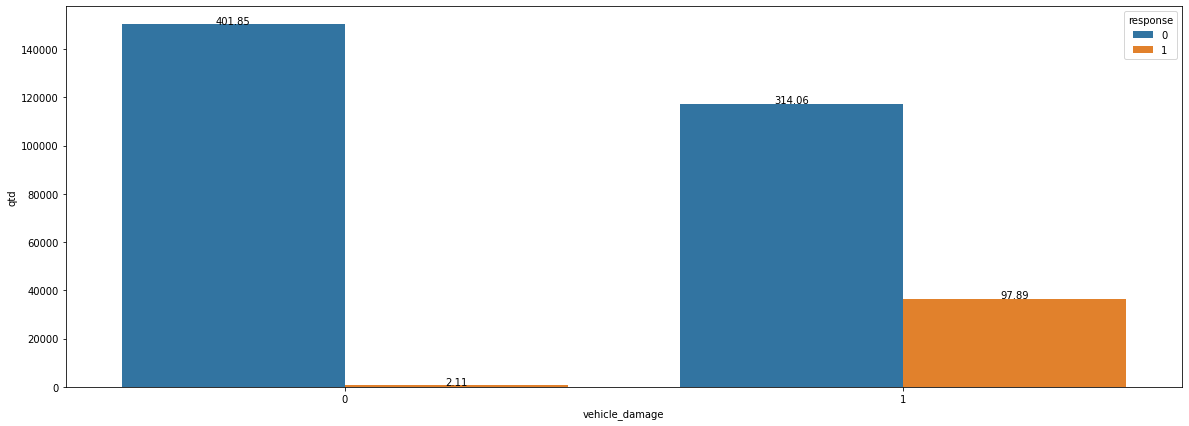

In [55]:
df_damage =df4[['vehicle_damage','response']].groupby(['vehicle_damage','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=df_damage,x='vehicle_damage',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

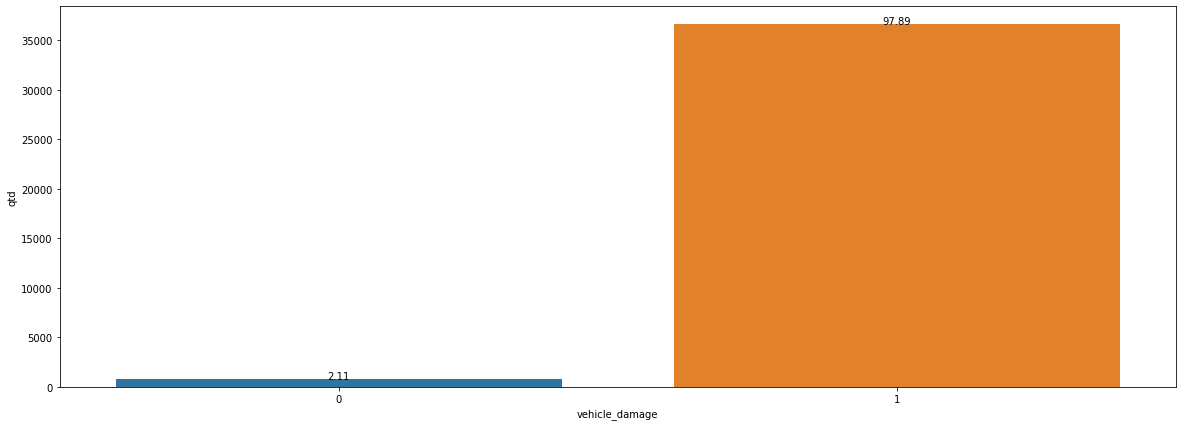

In [56]:
df_damage=df_damage[df_damage['response']==1]
ax = sns.barplot(data=df_damage,x='vehicle_damage',y='qtd');
total=sum(df_damage['qtd'])

graphic_percentage(ax,total)

True hyphoteses: Interest is greater in customers who HAD VEHICLE DAMAGE
- 98% of the clients interested in the insuranse had already sufered any type of accident

### H5 - Interest is greater in Customers who HAD VEHICLE PREVIOUSLY INSURED.

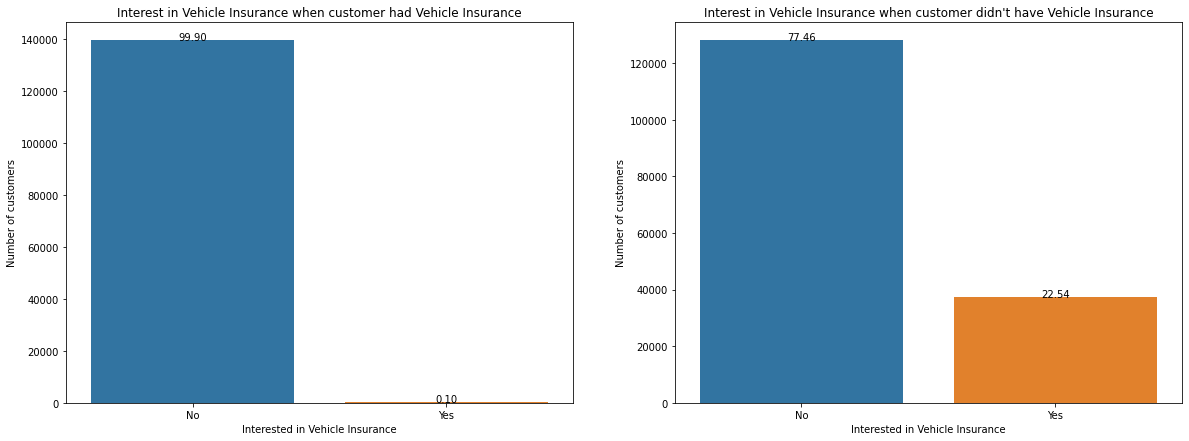

In [57]:
#previously_insured == 1(yes): interested / not interested
plt.subplot (1,2,1)
h5_df_insured = df4.loc[df4['previously_insured'] == 1]
h5_int_insured = h5_df_insured[['previously_insured', 'response']].groupby('response').count().reset_index()
fig_insured_h5 = sns.barplot (x = 'response', y='previously_insured', data=h5_int_insured);
fig_insured_h5.set_xlabel('Interested in Vehicle Insurance')
fig_insured_h5.set_ylabel('Number of customers')
fig_insured_h5.set_title('Interest in Vehicle Insurance when customer had Vehicle Insurance');
fig_insured_h5.set_xticklabels(['No', 'Yes']);
total= h5_df_insured['response'].count()
graphic_percentage(fig_insured_h5,total)

#previously_insured == 0(no): interested / not interested
plt.subplot (1,2,2)
h5_df_not_insured = df4.loc[df4['previously_insured'] == 0]
h5_int_not_insured = h5_df_not_insured[['previously_insured', 'response']].groupby('response').count().reset_index()
fig_not_insured_h5 = sns.barplot (x = 'response', y='previously_insured', data=h5_int_not_insured);
fig_not_insured_h5.set_xlabel('Interested in Vehicle Insurance')
fig_not_insured_h5.set_ylabel('Number of customers')
fig_not_insured_h5.set_title('Interest in Vehicle Insurance when customer didn\'t have Vehicle Insurance');
fig_not_insured_h5.set_xticklabels(['No', 'Yes']);
total= h5_df_not_insured['response'].count()
graphic_percentage(fig_not_insured_h5,total)

False hypothesis: 22% of customers who didn't have vehicle previously insured are interested in vehicle insurance, while only 1% of customers who had vehicle previously insured are interested.

### H6 - Interest is greater in customers with HIGHER ANNUAL HEALTH EXPANSES.

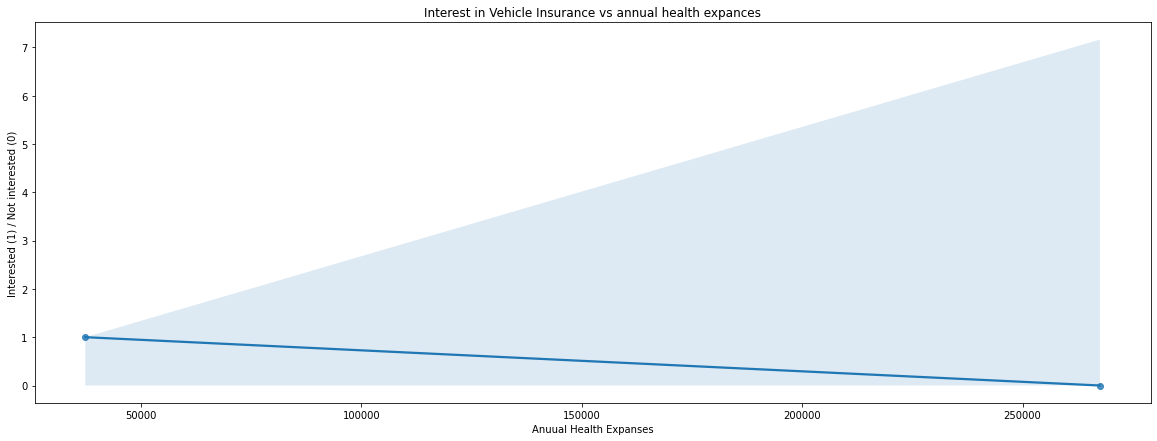

In [58]:
aux_h6 = df4[['annual_premium', 'response']].groupby('response').count().reset_index()
fig_h6 = sns.regplot (x= 'annual_premium', y='response', data=aux_h6)
fig_h6.set_xlabel('Anuual Health Expanses');
fig_h6.set_ylabel('Interested (1) / Not interested (0)')
fig_h6.set_title('Interest in Vehicle Insurance vs annual health expances');

False hypothesis: There is a decrease on interest of a vehicle insurance on higher annual health expenses.

### H7 -  Interest is greater in customers whth MORE DAYS ASSOCIATED.

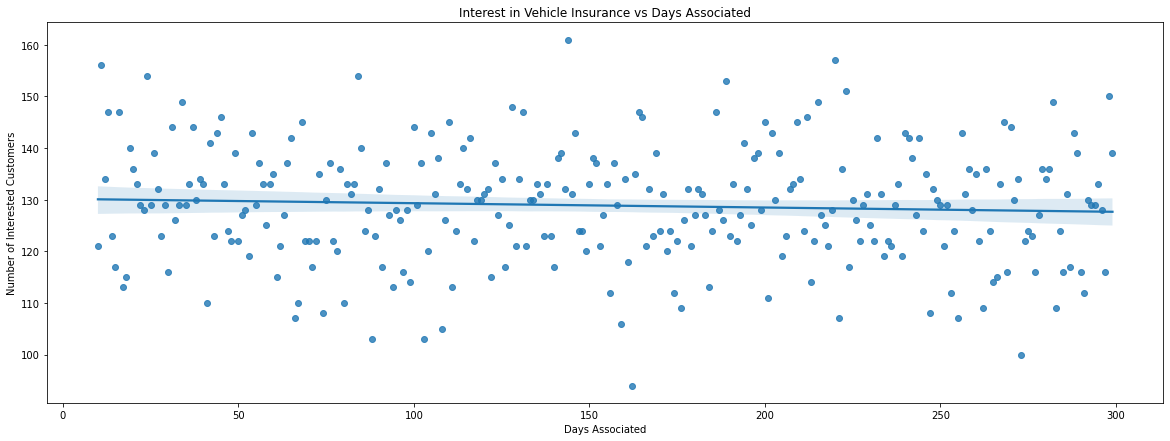

In [59]:
# get just the interested customers
aux_h7 = df4[['vintage', 'response']].groupby('vintage').sum().reset_index()
fig_h7 = sns.regplot (x= 'vintage', y='response', data=aux_h7)
fig_h7.set_xlabel('Days Associated');
fig_h7.set_ylabel('Number of Interested Customers')
fig_h7.set_title('Interest in Vehicle Insurance vs Days Associated');

False hypothesis: Customers with more days of health insurance (more days associated) have a bit less interest in vehicle insurance.

### Hypothesis conclusion

Good features in a Classification Project have a natural separation. The model aims to discover a cut in space to separate two classes. "Estimated Relevance" is a preliminary analysis, to be used later in Feature Selection.

In [60]:
#hypothesis tab
hyp_tab = [['Hypoteses', 'Conclusion', 'Estimated Relevance'],
       ['H1 - Interest is greater in customers with HIGHER AGE.', 'False', 'Medium'],
       ['H2 - Interest is greater in FEMALE CUSTOMERS.', 'False', 'Low'],
       ['H3 - Interest is greater in customers WITH MOST RECENT VEHICLE AGE.', 'False', 'High'],
       ['H4 - Interest is greater in customers who HAD VEHICLE DAMAGE.', 'True', 'High'],
       ['H5 - Interest is greater in Customers who HAD VEHICLE PREVIOUSLY INSURED.', 'False', 'High'],
       ['H6 - Interest is greater in customers with HIGHER ANNUAL HEALTH EXPANSES.', 'False', 'Low'],
       ['H7 - Interest is greater in customers whth MORE DAYS ASSOCIATED', 'False', 'Low'],
      ]
print(tabulate(hyp_tab, headers='firstrow', stralign='left', tablefmt='rst'))

=========================================================================  ============  =====================
Hypoteses                                                                  Conclusion    Estimated Relevance
=========================================================================  ============  =====================
H1 - Interest is greater in customers with HIGHER AGE.                     False         Medium
H2 - Interest is greater in FEMALE CUSTOMERS.                              False         Low
H3 - Interest is greater in customers WITH MOST RECENT VEHICLE AGE.        False         High
H4 - Interest is greater in customers who HAD VEHICLE DAMAGE.              True          High
H5 - Interest is greater in Customers who HAD VEHICLE PREVIOUSLY INSURED.  False         High
H6 - Interest is greater in customers with HIGHER ANNUAL HEALTH EXPANSES.  False         Low
H7 - Interest is greater in customers whth MORE DAYS ASSOCIATED            False         Low
============

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

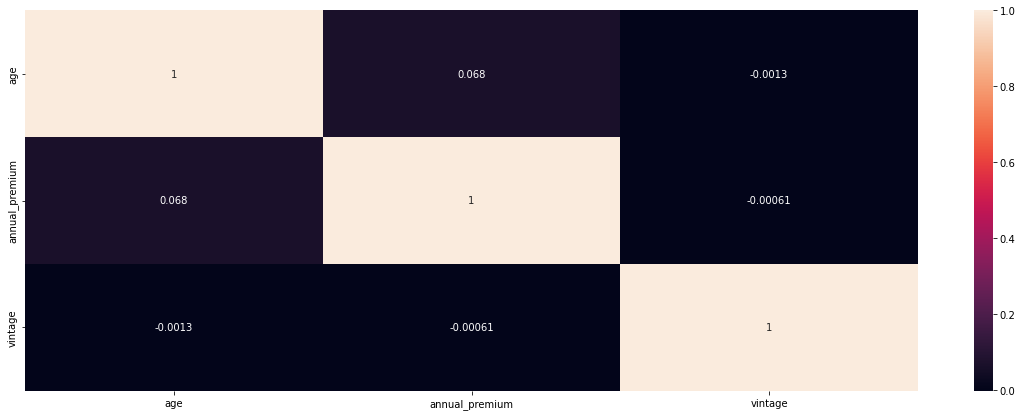

In [61]:
aux= num_attributes.corr()
sns.heatmap(aux,annot=True);

### 4.3.2. Categorical Attributes

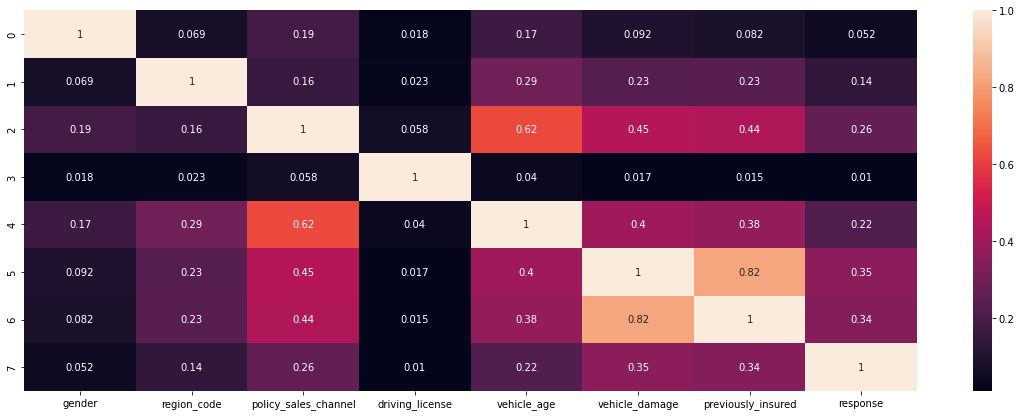

In [62]:
aux=pd.DataFrame(corr_cramer_v(cat_attributes))
sns.heatmap(aux,annot=True);

# 5.0. Data Preparation

In [63]:
df5 = df4.copy()

## 5.1. Standardization

In [64]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( '../../../../health_insurance_app/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [65]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( '../../../../health_insurance_app/features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( '../../../../health_insurance_app/features/vintage_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In [66]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../../../../health_insurance_app/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../../../../health_insurance_app/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../../../../health_insurance_app/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

In [67]:
# Prepared Training dataset:
df5

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
332579,332580,0.103991,0.261538,1,0.070701,0,1,-1.625561,0.028076,0.757785,0,0,1,0
318275,318276,0.103991,0.123077,1,0.101226,1,0,-0.119045,0.353482,0.615917,0,1,0,0
192458,192459,0.103991,0.307692,1,0.186638,0,0,-0.119627,0.193626,0.788927,0,0,1,0
126596,126597,0.103991,0.076923,1,0.116003,1,0,2.239430,0.353482,0.878893,0,1,0,0
318789,318790,0.103991,0.000000,1,0.041289,1,0,-1.625561,0.057067,0.318339,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95668,95669,0.138355,0.061538,1,0.090812,1,0,-0.158514,0.353482,0.851211,0,1,0,0
67756,67757,0.103991,0.046154,1,0.101256,0,1,-1.625561,0.353482,0.567474,1,1,0,0
235038,235039,0.138355,0.015385,1,0.103851,1,0,-0.165441,0.057067,0.020761,0,1,0,0
157375,157376,0.138355,0.446154,1,0.071463,0,1,0.344221,0.193626,0.024221,0,0,1,0


## 5.4. TEST Preparation

In [68]:
#load x_test and y_test from test data.

x_test = df_test
y_test = x_test['response']
x_test = x_test.drop('response', axis=1)
x_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
275163,275164,Female,24,1,41,1,< 1 Year,No,31696.0,152,62
228955,228956,Female,39,1,41,0,1-2 Year,Yes,34202.0,124,188
183986,183987,Female,25,1,39,0,< 1 Year,No,31140.0,152,200
272782,272783,Female,67,1,28,0,> 2 Years,Yes,2630.0,26,17
24900,24901,Male,23,1,46,1,< 1 Year,No,32159.0,152,149
...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,1,33,1,< 1 Year,No,32955.0,152,23
18930,18931,Male,49,1,40,0,> 2 Years,Yes,2630.0,124,277
135229,135230,Male,24,1,27,0,< 1 Year,No,26595.0,152,277
105049,105050,Male,22,1,29,1,< 1 Year,No,42844.0,152,140


In [69]:
# ----- Feature Engeneering ----- 
# Vehicle Damage Number
x_test['vehicle_damage'] = x_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
x_test['vehicle_age'] =  x_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

#--------Data Preparation---------

# gender
x_test.loc[:, 'gender'] =  x_test.loc[:, 'gender'].map( target_encode_gender )

# age
x_test.loc[:, 'age'] = mms_age.transform( x_test[['age']].values )

# region_code
x_test.loc[:, 'region_code'] = x_test.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_test = pd.get_dummies( x_test, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_test.loc[:, 'annual_premium'] = ss.transform( x_test[['annual_premium']].values )

# policy_sales_channel
x_test.loc[:, 'policy_sales_channel'] = x_test['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_test.loc[:, 'vintage'] = mms_vintage.transform( x_test[['vintage']].values )

# fillna
x_test = x_test.fillna( 0 )

In [70]:
x_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
275163,275164,0.103991,0.061538,1,0.122890,1,0,0.066483,0.353482,0.179931,1,0,0
228955,228956,0.103991,0.292308,1,0.122890,0,1,0.212366,0.193626,0.615917,0,1,0
183986,183987,0.103991,0.076923,1,0.123620,0,0,0.034116,0.353482,0.657439,1,0,0
272782,272783,0.103991,0.723077,1,0.186638,0,1,-1.625561,0.209901,0.024221,0,0,1
24900,24901,0.138355,0.046154,1,0.103851,1,0,0.093436,0.353482,0.480969,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,0.138355,0.107692,1,0.101226,1,0,0.139774,0.353482,0.044983,1,0,0
18930,18931,0.138355,0.446154,1,0.120316,0,1,-1.625561,0.193626,0.923875,0,0,1
135229,135230,0.138355,0.061538,1,0.073861,0,0,-0.230466,0.353482,0.923875,1,0,0
105049,105050,0.138355,0.030769,1,0.123155,1,0,0.715450,0.353482,0.449827,1,0,0


# 6.0. Feature Selection

In [71]:
df6 = df5.copy()

## 6.1. Validation Split

In [72]:
X = df6.drop(['response', 'id'], axis = 1).copy() # 304887 rows × 12 columns
y = df6['response'].copy() #Length: 304887

#Split Train into Val:
x_train, x_val, y_train, y_val = ms.train_test_split(X, y, stratify = y, test_size=0.10, random_state = 45)

In [73]:
#check split
print('x_train -> ',x_train.shape)
print('y_train -> ',y_train.shape)
print('x_val -> ',x_val.shape)
print('y_val -> ',y_val.shape)

x_train ->  (274398, 12)
y_train ->  (274398,)
x_val ->  (30489, 12)
y_val ->  (30489,)


## 6.1. Boruta Algorithm

In [301]:
x_train_n = x_train.values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [302]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Feature Importance

In [303]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = x_train
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.271031
0                annual_premium    0.241688
0                           age    0.166028
0                   region_code    0.107790
0                vehicle_damage    0.069579
0          policy_sales_channel    0.060813
0            previously_insured    0.054550
0      vehicle_age_below_1_year    0.014032
0  vehicle_age_between_1_2_year    0.006408
0                        gender    0.005211
0      vehicle_age_over_2_years    0.002335
0               driving_license    0.000536


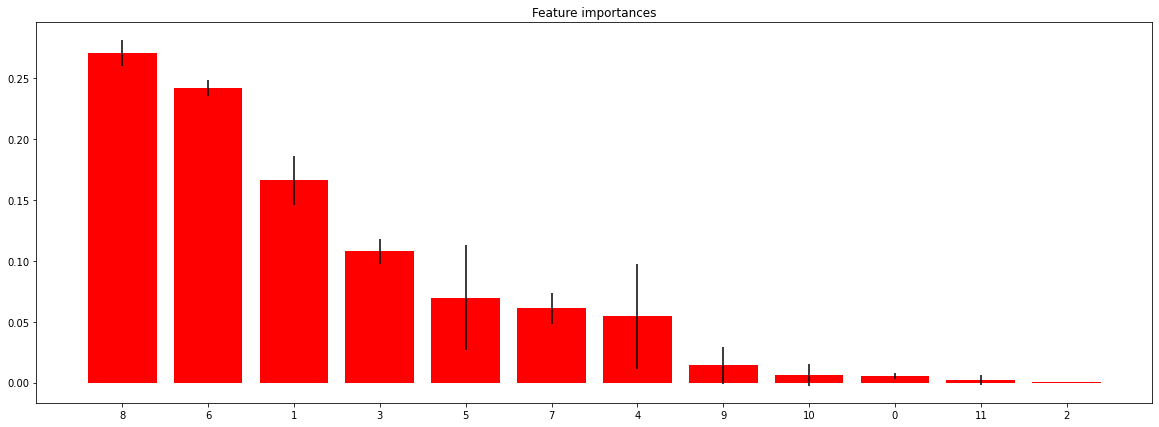

In [304]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

In [74]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [75]:
#new x data, only with cols selected:
x_train = x_train[ cols_selected ]
x_val = x_val[ cols_selected ]


In [76]:
# Since we have the capacity to do 20.000 calls an the len of our test Dataset is  76222 we know that we can make a call 
# to 26% of the available contacts, so let's use this value to select the best model in terms of precision and recall metrics
round(20000/len(df_test),2)

0.26

## 7.1. KNN Classifier

In [77]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

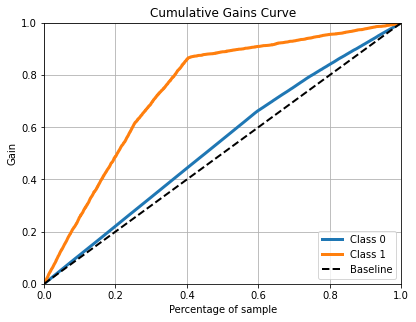

In [78]:
# Accumulative Gain
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

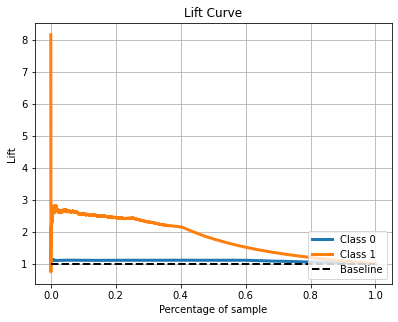

In [79]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

In [80]:
# number that corresponds to 26% of the base
n = round(0.26*len(y_val))
# copy data
df7 = x_val.copy()
df7['response'] = y_val.copy()
#propensity score
df7['score'] = yhat_knn[:,1].tolist()
# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)
# compute precision at k
precision_KNN = precision_at_k(df7, k= n)
print('Precision at K: {}'.format(precision_KNN))
# compute recall at k
recall_KNN = recall_at_k(df7, k = n)
print ('Recall at K: {}' .format(recall_KNN))

Precision at K: 0.29490413723511605
Recall at K: 0.6256355365266256


## 7.2. Logistic Regression

In [81]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

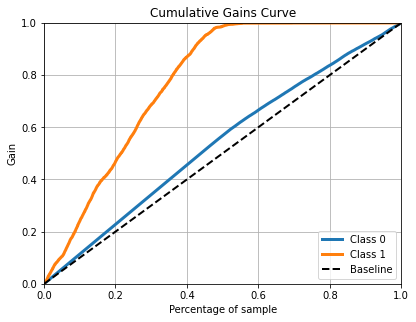

In [82]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

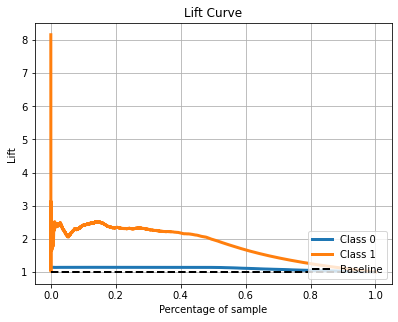

In [83]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

In [84]:
# number that corresponds to 26% of the base
n = round(0.26*len(y_val))
# copy data
df7 = x_val.copy()
df7['response'] = y_val.copy()
#propensity score
df7['score'] = yhat_lr[:,1].tolist()
# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)
# compute precision at k
precision_lr = precision_at_k(df7, k= n)
print('Precision at K: {}'.format(precision_lr))
# compute recall at k
recall_lr = recall_at_k(df7, k = n)
print ('Recall at K: {}' .format(recall_lr))

Precision at K: 0.28367810292633705
Recall at K: 0.6018196414236018


## 7.3. Extra Trees Classifier



In [85]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=50, n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )

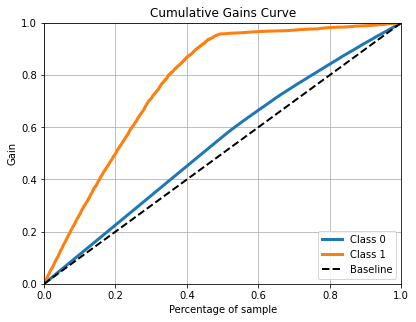

In [86]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

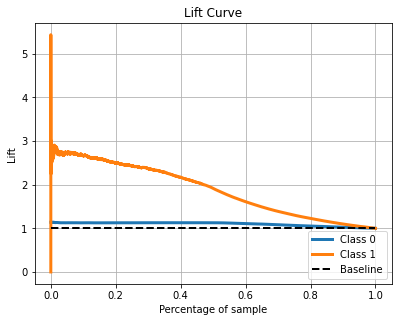

In [87]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_et );

In [88]:
# number that corresponds to 26% of the base
n = round(0.26*len(y_val))
# copy data
df7 = x_val.copy()
df7['response'] = y_val.copy()
#propensity score
df7['score'] = yhat_et[:,1].tolist()
# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)
# compute precision at k
precision_et = precision_at_k(df7, k= n)
print('Precision at K: {}'.format(precision_et))
# compute recall at k
recall_et = recall_at_k(df7, k = n)
print ('Recall at K: {}' .format(recall_et))

Precision at K: 0.29591321897073664
Recall at K: 0.6277762911426278


## 7.4. Random Forest

In [89]:
# model definition
rf = en.RandomForestClassifier( n_estimators=50, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = et.predict_proba( x_val )

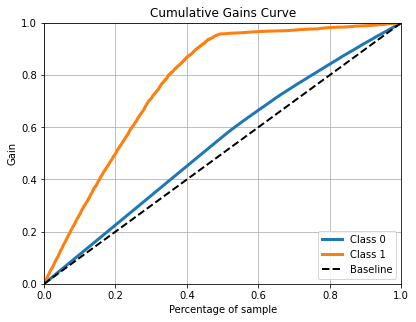

In [90]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

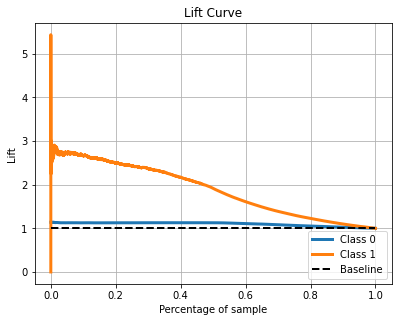

In [91]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

In [92]:
# number that corresponds to 26% of the base
n = round(0.26*len(y_val))
# copy data
df7 = x_val.copy()
df7['response'] = y_val.copy()
#propensity score
df7['score'] = yhat_rf[:,1].tolist()
# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)
# compute precision at k
precision_rf = precision_at_k(df7, k= n)
print('Precision at K: {}'.format(precision_rf))
# compute recall at k
recall_rf = recall_at_k(df7, k = n)
print ('Recall at K: {}' .format(recall_rf))

Precision at K: 0.29591321897073664
Recall at K: 0.6277762911426278


## 7.5. XGBoost 

In [93]:
xgb_model = XGBClassifier()

model_xgb = xgb_model.fit(x_train,y_train.values.ravel())

yhat_proba_xgb = model_xgb.predict_proba(x_val)

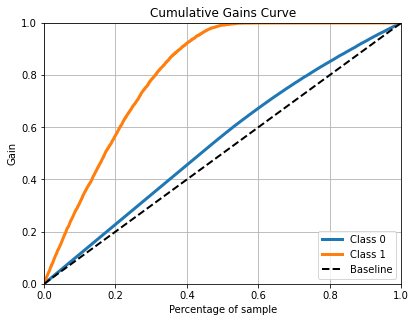

In [94]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_proba_xgb );

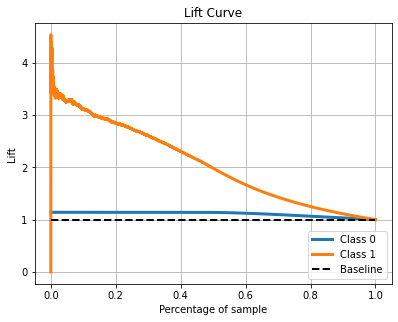

In [95]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_proba_xgb);

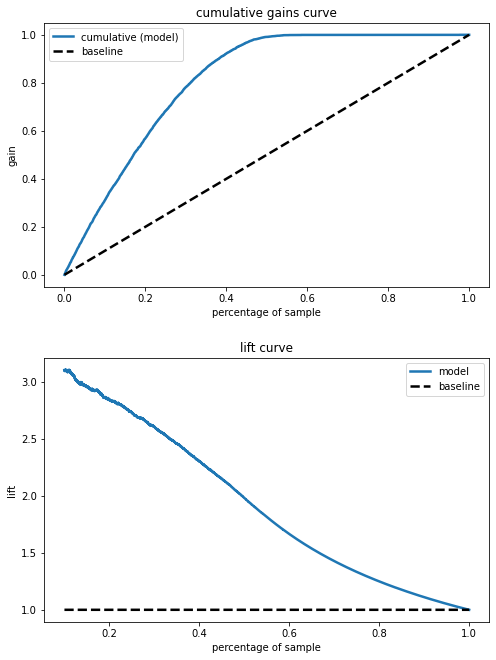

In [96]:
table_xgb = gain_lift_curve(yhat_proba_xgb, y_val, plot = True)


In [97]:
metrics_xgb, new_table_xgb = precision_recall_at_k(table_xgb, n) 

In [98]:
new_table_xgb

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.576325,0.423675,0,yes,0.000000,0.000000,0.000033,0.000000,1,0.000000,0.000000
1,0.576325,0.423675,1,no,0.000268,0.000268,0.000066,4.079342,2,0.500000,0.000268
2,0.576325,0.423675,0,yes,0.000000,0.000268,0.000098,2.719561,3,0.333333,0.000268
3,0.576325,0.423675,0,yes,0.000000,0.000268,0.000131,2.039671,4,0.250000,0.000268
4,0.576325,0.423675,0,yes,0.000000,0.000268,0.000164,1.631737,5,0.200000,0.000268
...,...,...,...,...,...,...,...,...,...,...,...
30484,0.999614,0.000386,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122585,1.000000
30485,0.999640,0.000360,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122581,1.000000
30486,0.999640,0.000360,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122577,1.000000
30487,0.999643,0.000357,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122573,1.000000


In [99]:
print(f"XGBoost - \nPrecision at 26% of base(k): {round( metrics_xgb[0] ,2)}\nRecall at 26% of base(k): {round( metrics_xgb[1] ,2) }")

XGBoost - 
Precision at 26% of base(k): 0.33
Recall at 26% of base(k): 0.7


In [100]:
# number that corresponds to 26% of the base
n = round(0.26*len(y_val))
# copy data
df7 = x_val.copy()
df7['response'] = y_val.copy()
#propensity score
df7['score'] = yhat_proba_xgb[:,1].tolist()
# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)
# compute precision at k
precision_proba_xgb = precision_at_k(df7, k= n)
print('Precision at K: {}'.format(precision_proba_xgb))
# compute recall at k
recall_proba_xgb = recall_at_k(df7, k = n)
print ('Recall at K: {}' .format(recall_proba_xgb))

Precision at K: 0.33110494450050454
Recall at K: 0.7024351083757024


In [101]:
compare_models_dict = {'Model': ['KNN Classifier','Logistic Regression','Extra Trees Classifier', 'Random Forest', 'XGBoost'],\
                       'Precision at 26%':[precision_KNN, precision_lr, precision_et, precision_rf, precision_proba_xgb],\
                       'Recall at 26%':[recall_KNN, recall_lr, recall_et, recall_rf, recall_proba_xgb]}
c_mdf = pd.DataFrame(compare_models_dict).sort_values(by='Precision at 26%', ascending =False).reset_index().drop(columns='index')
c_mdf

,Model,Precision at 26%,Recall at 26%
0,XGBoost,0.331105,0.702435
1,Extra Trees Classifier,0.295913,0.627776
2,Random Forest,0.295913,0.627776
3,KNN Classifier,0.294904,0.625636
4,Logistic Regression,0.283678,0.601820


In [ ]:
# Since in this crispy cicle we have decided to use XGBoost model, becouse it has the bests Precision and Recal, we are going to
# tune this model with some option of Param and then we'll use cross validation, to reduce the selection bias of the indicators

In [455]:
## session with high processing time: ??
## results compiled in the following table

param = {
    'n_estimators':  [100, 110, 120],
    'max_depth': [2,3,4], 
    'scale_pos_weight': [1, 2]
}

max_eval = 5

for i in range(max_eval):
    # random choice of dictionary values
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)

    # model definition
    xgb_model = XGBClassifier(n_estimators = hp['n_estimators'],
                                        max_depth = hp['max_depth'],
                                        scale_pos_weight = hp['scale_pos_weight'],
                                        n_jobs= -1)
    
    
    display(runCrossValidation(xgb_model, x_train, x_val, y_train, y_val, n_splits = 10, n_repeats = 2, top_k = n ))

{'n_estimators': 100, 'max_depth': 2, 'scale_pos_weight': 2}


,mean,std
precision_at_k,0.329570,0.002956
recall_at_k,0.699128,0.006302


{'n_estimators': 120, 'max_depth': 3, 'scale_pos_weight': 1}


,mean,std
precision_at_k,0.332913,0.002856
recall_at_k,0.706219,0.006080


{'n_estimators': 100, 'max_depth': 2, 'scale_pos_weight': 2}


,mean,std
precision_at_k,0.329570,0.002956
recall_at_k,0.699128,0.006302


{'n_estimators': 100, 'max_depth': 3, 'scale_pos_weight': 1}


,mean,std
precision_at_k,0.332093,0.003029
recall_at_k,0.704480,0.006449


{'n_estimators': 110, 'max_depth': 4, 'scale_pos_weight': 1}


,mean,std
precision_at_k,0.333714,0.002653
recall_at_k,0.707919,0.005659


In [102]:
final_results = {'model':['#1', '#2', '#3', '#4', '#5'],
                 'precision_at_k': ['0.329570 +/- 0.002956',
                                    '0.332913 +/- 0.002856',
                                    '0.329570 +/- 0.002956',
                                    '0.332093 +/- 0.003029',
                                    '0.333714 +/- 0.002653'],
                 'recall_at_k': ['0.699128 +/- 0.006302',
                                 '0.706219 +/- 0.006080',
                                 '0.699128 +/- 0.006302',
                                 '0.704480 +/- 0.006449',
                                 '0.707919 +/- 0.005659'],
                 'parameters': ["'n_estimators': 100, 'max_depth': 2, 'scale_pos_weight': 2",
                                "'n_estimators': 120, 'max_depth': 3, 'scale_pos_weight': 1",
                                "'n_estimators': 100, 'max_depth': 2, 'scale_pos_weight': 2",
                                "'n_estimators': 100, 'max_depth': 3, 'scale_pos_weight': 1",
                                "'n_estimators': 110, 'max_depth': 4, 'scale_pos_weight': 1"]
                }

print(tabulate(final_results, headers=['model','precision@k','recall@k', 'hyperparameters'], tablefmt="fancy_grid"))

╒═════════╤═══════════════════════╤═══════════════════════╤════════════════════════════════════════════════════════════╕
│ model   │ precision@k           │ recall@k              │ hyperparameters                                            │
╞═════════╪═══════════════════════╪═══════════════════════╪════════════════════════════════════════════════════════════╡
│ #1      │ 0.329570 +/- 0.002956 │ 0.699128 +/- 0.006302 │ 'n_estimators': 100, 'max_depth': 2, 'scale_pos_weight': 2 │
├─────────┼───────────────────────┼───────────────────────┼────────────────────────────────────────────────────────────┤
│ #2      │ 0.332913 +/- 0.002856 │ 0.706219 +/- 0.006080 │ 'n_estimators': 120, 'max_depth': 3, 'scale_pos_weight': 1 │
├─────────┼───────────────────────┼───────────────────────┼────────────────────────────────────────────────────────────┤
│ #3      │ 0.329570 +/- 0.002956 │ 0.699128 +/- 0.006302 │ 'n_estimators': 100, 'max_depth': 2, 'scale_pos_weight': 2 │
├─────────┼─────────────────────

## Model Training 

In [103]:
# model definition
xgbclassifier_model = XGBClassifier(n_estimators = 110,
                                    max_depth = 4,
                                    scale_pos_weight = 1,
                                    n_jobs= -1)

# model training
xgbclassifier_model.fit(x_train, y_train.values.ravel())

# model prediction (proba)
yhat_proba = xgbclassifier_model.predict_proba(x_val)

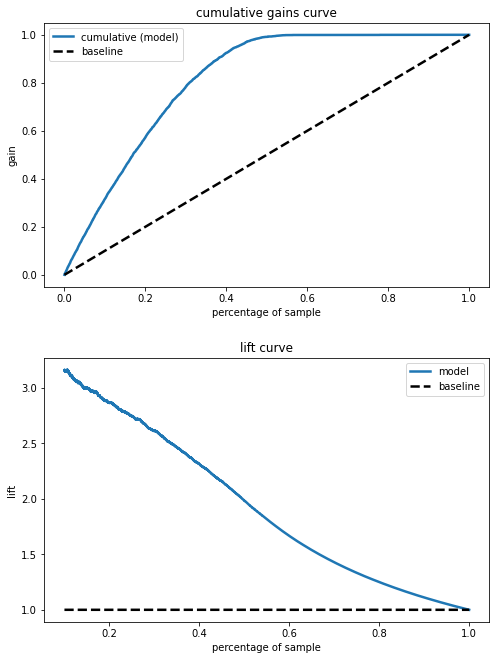

In [104]:
table_xgb = gain_lift_curve(yhat_proba, y_val)
metrics_xgb, new_table_xgb = precision_recall_at_k(table_xgb, n) 


In [105]:
#XGBoost: Metrics of precision@k and recall@k -> k=12200 (40% of base).
metrics_xgb

(0.33253437618266685, 0.7053786459727054)

## Model Test

 - In this section, let's train the XGBoost classifier with x_train and x_val datasets, and test using x_test dataset.
 - In this way, it will be possible to compare the performance of the model with training and validation data, and with test data.
 - It will then be possible to assess the model's generalizability, that is, the model's ability to rank never seen data.

In [106]:
# unify train and validation datasets
x_train = pd.concat([x_train, x_val])
y_train = pd.concat([y_train, y_val])


# model definition
xgbclassifier_model = XGBClassifier(n_estimators = 110,
                                    max_depth = 4,
                                    scale_pos_weight = 1,
                                    n_jobs= -1)

# model training
xgbclassifier_model.fit(x_train, y_train.values.ravel())

# model prediction (proba)
yhat_proba_xgb_final = xgbclassifier_model.predict_proba(x_test[cols_selected])

## Cumulative Gains and Lift Curves

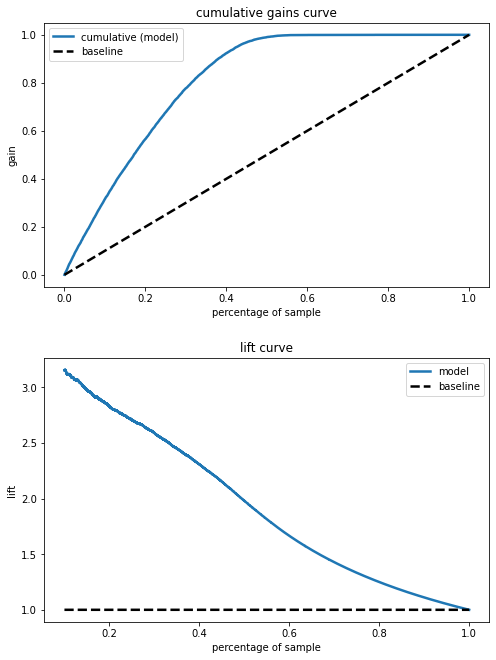

In [107]:
table_xgb_test = gain_lift_curve(yhat_proba_xgb_final, y_test)
metrics_xgb_test, new_table_xgb_test = precision_recall_at_k(table_xgb_test, 20000) 


In [108]:
metrics_xgb_test

(0.3281, 0.7024191821879683)

# 8.0. Performance Metrics

## 8.1. Performance at 20.000 Calls 

In [109]:
data = x_test.copy()
data['target'] = y_test.copy()
data['response'] = yhat_proba_xgb_final[:, 1].tolist()
data = data.sort_values('response', ascending=False)

Percent of Data:  0.26
Recall at 20000:  0.7
Precision at 20000:  0.33


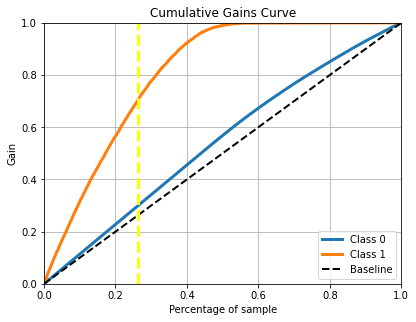

In [110]:
percent_of_dataset = 20000 / len(df_test)
recall_at_20000 = recall_at_k(data, 20000)
precision_at_20000 = precision_at_k(data,20000)
print('Percent of Data: ',round(percent_of_dataset,2))
print('Recall at 20000: ',round(recall_at_20000,2))
print('Precision at 20000: ',round(precision_at_20000,2))

# skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_xgb_final)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 


By using 26% of test data, in which would translate as 20 thousand calls by the sales team, the model would be able to identify 70% people out of the total people interested in purchasing the insurance.

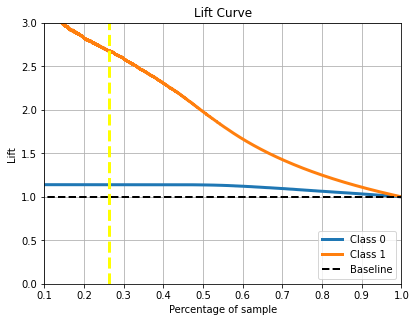

In [111]:
skplt.metrics.plot_lift_curve(y_test, yhat_proba_xgb_final)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

 By Making 20 thousand calls, the model proposed is roughly 2,7 times better than random choice.

### 8.1.1. Revenue by making 20.000 Calls in the test list with 76222 contacts

In [112]:
df_test['response'].value_counts()

0    66880
1     9342
Name: response, dtype: int64

In [113]:
random_choice = round((26/100) * df_test['response'].sum())
model         = round((70/100) * df_test['response'].sum())

x = random_choice * (2000)
y = model * (2000)
dif=y-x

print('{} customers hit with random choice'.format(random_choice))
print('{} customers hit with model'.format(model))
print('{} Annual revenue with random choice'.format(x))
print('{} Annual revenue with model'.format(y))
print('difference in $: {} '.format(dif)  )

2429 customers hit with random choice
6539 customers hit with model
4858000 Annual revenue with random choice
13078000 Annual revenue with model
difference in $: 8220000 


## 8.2. Performance at 40.000 Calls

Percent of Data:  0.5247828710870878
Recall at 40000:  0.993452382131687
Precision at 40000:  0.2322164055500911


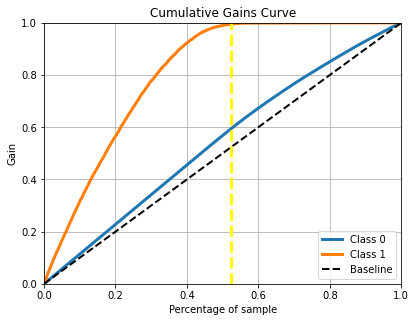

In [114]:
percent_of_dataset = 40000 / len(data)
recall_at_40000 = recall_at_k(data, k = 40000)
precision_at_40000=precision_at_k(data,k=40000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 40000: ',recall_at_40000)
print('Precision at 40000: ',precision_at_40000)

# skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_xgb_final)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

By using 52,47% of test data, in which wold translate as 40 thousand calls by the sales team, the model would be able to identify 99.36% people out of the total people interested in purchasing the insurance.

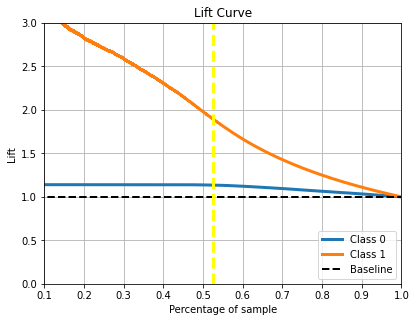

In [115]:
skplt.metrics.plot_lift_curve(y_test, yhat_proba_xgb_final)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

By Making 40 thousand calls, the model proposed is roughly 1,9 times better than random choice.

### 8.1.2. Revenue by making 40.000 Calls in the test list with 76222 contacts

In [116]:
random_choice = round((52/100) * df_test['response'].sum())
model         = round((99/100) * df_test['response'].sum())

x = random_choice * (2000)
y = model * (2000)
dif=y-x

print('{} customers hit with random choice'.format(random_choice))
print('{} customers hit with model'.format(model))
print('{} Annual revenue with random choice'.format(x))
print('{} Annual revenue with model'.format(y))
print('difference in $: {} '.format(dif)  )

4858 customers hit with random choice
9249 customers hit with model
9716000 Annual revenue with random choice
18498000 Annual revenue with model
difference in $: 8782000 


## 8.3. How many calls to reach 80% of people interested

In [118]:
percent_at_24k = 24000 / len(data)
recall_at_24k, table_24k = precision_recall_at_k(data, k=24000)

print('To reach 80% of people interested, we have to call about 24000 persons of the base')
print('That represents {}% of the base'.format (round(percent_at_24k, 2)*100))
print('Since we are going to reach 80% of interested parties, our recall indicator also has to be {}%'.format(round(recall_at_24k[1], 2)*100))

To reach 80% of people interested, we have to call about 24000 persons of the base
That represents 31.0% of the base
Since we are going to reach 80% of interested parties, our recall indicator also has to be 80.0%


# 9.0. Deploy to Production

In [119]:
# Save trained model

pickle.dump( xgbclassifier_model, open( '../../../../health_insurance_app/models/model_health_insurance.pkl', 'wb' ) )


## 9.1. Health Insurance Class

In [106]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance ( object ):
    
    def __init__( self ):
        self.home_path = ''
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'features/age_scaler.pkl', 'rb' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'features/vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'features/target_encode_region_code_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred[:,1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler

In [111]:
import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
path = ''
model = pickle.load( open( path + 'models/model_health_insurance.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    port = os.environ.get ('PORT', 5000)
    app.run( host = '0.0.0.0', port = port )

KeyboardInterrupt: 

## 9.3. API Tester

In [144]:
import requests
import json

In [145]:
# loading full test dataset with 76222 rows (simulating production)
df_test = pd.read_csv('../data/full_test_data.csv', index_col=0) #3 rows of data
df_test = df_test.sample(1000)


In [146]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [147]:
# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-prediction-r.herokuapp.com/healthinsurance/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [149]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'prediction', ascending=False ).head(50)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction
673,42752,0.138355,0.153846,1,0.116003,0,below_1_year,1,-0.452144,124,0.044983,0,0.462773
482,6199,0.138355,0.153846,1,0.122368,0,between_1_2_year,1,-0.377864,124,0.840830,1,0.451053
571,312199,0.138355,0.215385,1,0.126449,0,below_1_year,1,-0.516121,26,0.903114,1,0.449739
233,3974,0.103991,0.230769,1,0.116003,0,between_1_2_year,1,-0.168294,124,0.242215,0,0.448486
723,318814,0.103991,0.215385,1,0.116003,0,between_1_2_year,1,-0.216961,124,0.429066,1,0.448486
255,298320,0.103991,0.184615,1,0.122890,0,below_1_year,1,-0.093198,124,0.128028,0,0.444059
216,231228,0.138355,0.153846,1,0.137028,0,between_1_2_year,1,-0.146522,163,0.754325,0,0.425776
197,126766,0.138355,0.153846,1,0.186638,0,below_1_year,1,-0.275989,124,0.847751,1,0.424820
714,209805,0.138355,0.230769,1,0.123155,0,between_1_2_year,1,-0.434040,154,0.743945,1,0.424227
210,115674,0.138355,0.169231,1,0.130825,0,between_1_2_year,1,0.189663,124,0.788927,0,0.424155
